# Transfer learning for Glaucoma and Normal Eye Fundus

## Libraries

In [231]:
import os
import csv
import PIL
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, model_from_json, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

In [232]:
tf.__version__

'2.10.0'

## Data exploration

In [233]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\Kuliah\\Proyek Akhir 2022\\dataset_glaucoma_normal.csv'
headers = ['Image', 'Label']

In [234]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [235]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Glaucoma-Normal)\\'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [236]:
# Load and preview the CSV dataset file

glaucoma_df = pd.read_csv('D:\\Kuliah\\Proyek Akhir 2022\\dataset_glaucoma_normal.csv')
glaucoma_df

,Image,Label
0,BEH-1.png,Glaucoma
1,BEH-10.png,Glaucoma
2,BEH-100.png,Glaucoma
3,BEH-101.png,Glaucoma
4,BEH-102.png,Glaucoma
...,...,...
9529,sjchoi86-HRF-89.png,Normal
9530,sjchoi86-HRF-91.png,Normal
9531,sjchoi86-HRF-93.png,Normal
9532,sjchoi86-HRF-97.png,Normal


In [237]:
# The dataset inside the CSV file has around 9534 list of images

print('Glaucoma dataset shape:', glaucoma_df.shape)
print('Glaucoma dataset axes:', glaucoma_df.axes)

Glaucoma dataset shape: (9534, 2)
Glaucoma dataset axes: [RangeIndex(start=0, stop=9534, step=1), Index(['Image', 'Label'], dtype='object')]


In [238]:
# Print the classes used for the classification

print('The labels are:', glaucoma_df['Label'].unique())

The labels are: ['Glaucoma' 'Normal']


In [239]:
# Count each class images

print(glaucoma_df.groupby('Label')['Image'].nunique())

print('\nType:', type(glaucoma_df.groupby('Label')['Image'].nunique()))

label_count = glaucoma_df.groupby('Label')['Image'].nunique()
label_count = label_count.to_numpy()
print('\nLabel count:', label_count)

Label
Glaucoma    4767
Normal      4767
Name: Image, dtype: int64

Type: <class 'pandas.core.series.Series'>

Label count: [4767 4767]


In [240]:
print(glaucoma_df.iloc[[0]]['Image'])
print(glaucoma_df.iloc[[100]]['Image'])

0    BEH-1.png
Name: Image, dtype: object
100    BEH-35.png
Name: Image, dtype: object


[Text(0, 0, '4767'), Text(0, 0, '4767')]

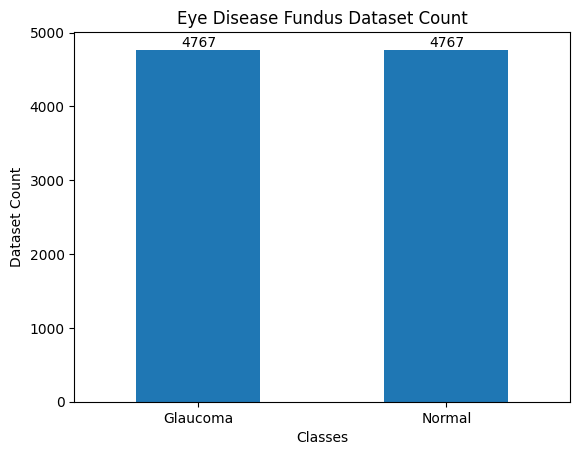

In [241]:
# Plotting the dataset count in each class

dataset_df_chart = glaucoma_df.groupby('Label')['Image'].nunique().plot(kind='bar', 
                                                                        title='Eye Disease Fundus Dataset Count',
                                                                        xlabel='Classes',
                                                                        ylabel='Dataset Count',
                                                                        rot=0)

dataset_df_chart.bar_label(dataset_df_chart.containers[0])

In [242]:
# Set the dataset base directory

os.chdir('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Glaucoma-Normal) (Splitted)')
dataset_dir = os.getcwd()
print('Dataset directory:', dataset_dir)

Dataset directory: D:\Kuliah\Proyek Akhir 2022\Dataset (Glaucoma-Normal) (Splitted)


In [243]:
# Set the train, val, and test dataset path

train_url = dataset_dir + '\\train'
val_url = dataset_dir + '\\val'
test_url = dataset_dir + '\\test'

train_dir = pathlib.Path(train_url)
val_dir = pathlib.Path(val_url)
test_dir = pathlib.Path(test_url)

print('train_url\t:', train_url)
print('val_url\t\t:', val_url)
print('test_url\t:', test_url)

print('\ntrain_dir\t:', train_dir)
print('val_dir\t\t:', val_dir)
print('test_dir\t:', test_dir)

train_url	: D:\Kuliah\Proyek Akhir 2022\Dataset (Glaucoma-Normal) (Splitted)\train
val_url		: D:\Kuliah\Proyek Akhir 2022\Dataset (Glaucoma-Normal) (Splitted)\val
test_url	: D:\Kuliah\Proyek Akhir 2022\Dataset (Glaucoma-Normal) (Splitted)\test

train_dir	: D:\Kuliah\Proyek Akhir 2022\Dataset (Glaucoma-Normal) (Splitted)\train
val_dir		: D:\Kuliah\Proyek Akhir 2022\Dataset (Glaucoma-Normal) (Splitted)\val
test_dir	: D:\Kuliah\Proyek Akhir 2022\Dataset (Glaucoma-Normal) (Splitted)\test


In [244]:
# Image count in each dataset

train_count = len(list(train_dir.glob('*/*')))
val_count = len(list(val_dir.glob('*/*')))
test_count = len(list(test_dir.glob('*/*')))

print('Total training set images:\t', train_count)
print('Total validation set images\t:', val_count)
print('Total test set images\t\t:', test_count)

Total training set images:	 9056
Total validation set images	: 238
Total test set images		: 240


In [245]:
# Create dictionary of datagens and generators from each dataset

data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}

data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

### Find the classes distribution

Train information
---------------
Label names		: ['Glaucoma', 'Normal']
Label counts		: [4528, 4528]
Total image count	: 9056 

Val information
---------------
Label names		: ['Glaucoma', 'Normal']
Label counts		: [119, 119]
Total image count	: 238 

Test information
---------------
Label names		: ['Glaucoma', 'Normal']
Label counts		: [120, 120]
Total image count	: 240 



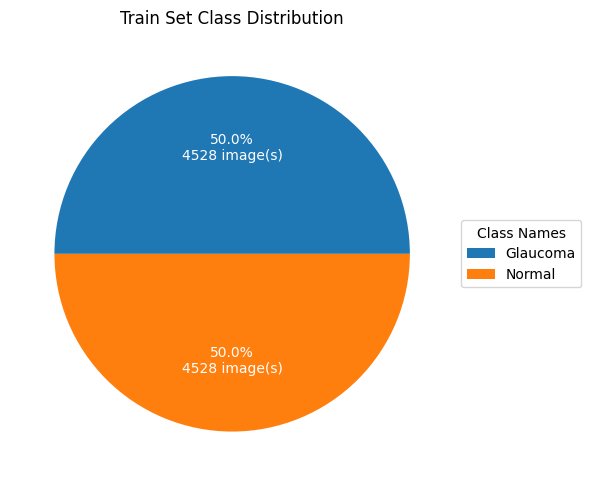

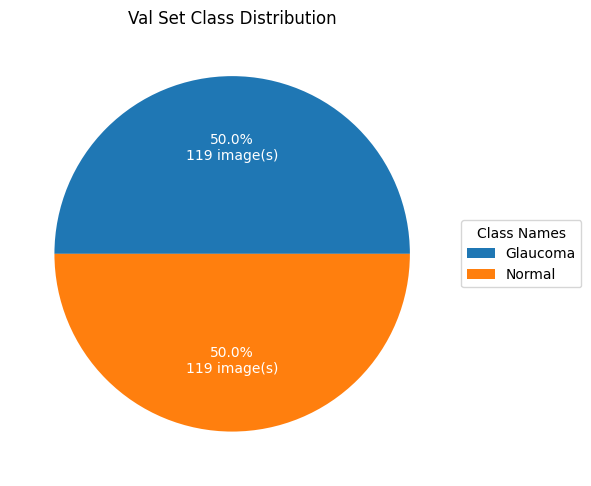

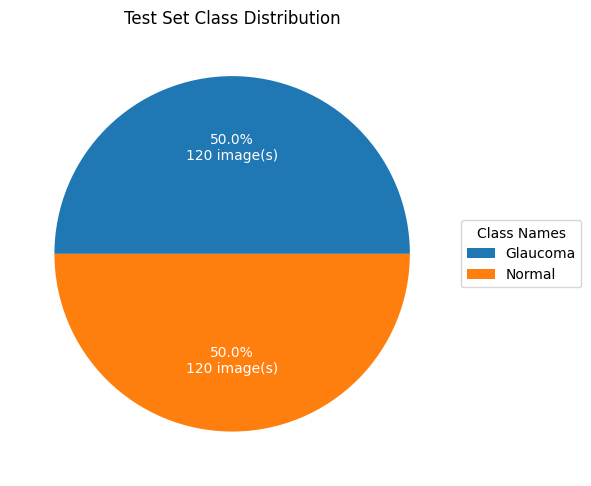

In [246]:
# Set and plot each dataset's classes distribution

for phase in ['train', 'val', 'test']:
    if phase == 'train':
        data_dir = train_dir
    elif phase == 'val':
        data_dir = val_dir
    elif phase == 'test':
        data_dir = test_dir

    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names) 

    image_files = [[
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ] for i in range(num_class)]

    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = [] 
    image_class = []

    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])

    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    
    print(f'{phase.capitalize()} information')
    print('-'*15)
    print(f'Label names\t\t: {class_names}')
    print(f'Label counts\t\t: {num_each}')
    print(f'Total image count\t: {num_total}', '\n')

    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n{absolute:d} image(s)"

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(num_each, 
                                        labels=class_names, 
                                        autopct=lambda pct: func(pct, num_each), 
                                        textprops=dict(color='w'))
    ax.legend(wedges, 
                class_names,
                title='Class Names',
                loc='center left',
                bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(f'{phase.capitalize()} Set Class Distribution')
    plt.tight_layout()

In [247]:
# Set some training hyperparameters

BATCH_SIZE = 32

IMG_SIZE_1 = 32
IMG_SIZE_2 = 64
IMG_SIZE_3 = 100
IMG_SIZE_4 = 128
IMG_SIZE_5 = 180
IMG_SIZE_6 = 224
IMG_SIZE_7 = 256
IMG_SIZE = (IMG_SIZE_3, IMG_SIZE_3)

print('BATCH_SIZE:', BATCH_SIZE)
print('IMG_SIZE:', IMG_SIZE, '| IMG_SIZE type:', type(IMG_SIZE))

BATCH_SIZE: 32
IMG_SIZE: (100, 100) | IMG_SIZE type: <class 'tuple'>


## Data loading & augmentation

In [248]:
# Create the datagen for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

from tensorflow.keras.applications.mobilenet_v3 import preprocess_input # Adjust with the model we want to use

datagen = {
    'train': ImageDataGenerator(
        # rescale=1/255.0,
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='constant',
        # shear_range=5.0,
        # zoom_range=[0.5, 1.0],
        # brightness_range=(0.5, 1.5),
        # width_shift_range=(0.0, 0.15),
        # height_shift_range=(0.0, 0.15),
        # preprocessing_input=preprocess_input

    ),
    'val': ImageDataGenerator(
        # rescale=1/255.0,
    ),
    'test': ImageDataGenerator(
        # rescale=1/255.0,
    ),
}

In [249]:
# Create the image generator for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\glaucoma_test_images\\EyePACS-Glaucoma-126.png'
augmentation_dest_path = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\glaucoma_augmentations_examples'

data_sets = {
    'train': datagen['train'].flow_from_directory(
        train_dir, 
        shuffle=True, 
        seed=42, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,

        # Uncomment this beneath line if we want to preview and save some augmented images
        # save_to_dir=augmentation_dest_path,
        # save_prefix='aug',
        # save_format='png'
    ),
    'val': datagen['val'].flow_from_directory(
        val_dir, 
        shuffle=True, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,
    ),
    'test': datagen['test'].flow_from_directory(
        test_dir, 
        shuffle=False, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE
    )
}

Found 9056 images belonging to 2 classes.
Found 238 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [250]:
# Uncomment this section if we want to preview and save some augmented images

# 
# test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\glaucoma_test_images\\EyePACS-Glaucoma-126.png'
# augmentation_dest_path = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\glaucoma_augmentations_examples'
# 
# i = 0
# 
# for batch in data_sets['train']:
#     i = i + 1
#     if i >= 30:
#         break

In [251]:
# Let's take a look at the dataset properties after being created with ImageDataGenerator 

for i, (images, labels) in enumerate(data_sets['train']):
    print('First batch labels:', labels)
    print('Labels shape:', labels.shape)
    print('Images shape:', images.shape)
    break

First batch labels: [1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1.]
Labels shape: (32,)
Images shape: (32, 100, 100, 3)


### Preview the image dataset

In [268]:
# # Show the nine images and labels from the dataset
# 
# def show_images(GRID=[3,3], model=None, size=(8,8), data_type='train'):
#     n_rows = GRID[0]
#     n_cols = GRID[1]
#     n_images = n_cols * n_rows
#     i = 1
#     plt.figure(figsize=size)
# 
#     data = data_sets[data_type]
# 
#     for images, labels in data:
#         id = np.random.randint(32)
#         image, label = images[id], class_names[int(labels[id])]
#         
#         plt.subplot(n_rows, n_cols, i)
#         plt.imshow(image.astype('uint8'))
#         
#         # if model is None:
#         #     title = f"Class : {label}"
#         # else:
#         #     pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
#         #     title = f"Org : {label}, Pred : {pred}"
#         
#         plt.title(title)
#         
#         if data_type == 'train':
#             plt.suptitle('Preprocessed/Augmented Train Images')
#         elif data_type == 'val':
#             plt.suptitle('Preprocessed/Augmented Validation Images')
#         elif data_type == 'test':
#             plt.suptitle('Preprocessed/Augmented Test Images')
# 
#         plt.axis('on')
#         i+=1
#         
#         if i>=(n_images+1):
#             break
#             
#     plt.tight_layout()
#     plt.show()

def show_images(dataset_type):
    if dataset_type not in ['train', 'val', 'test']:
        raise ValueError("Invalid dataset_type. Choose 'train', 'val', or 'test'.")

    # Set the path to your dataset directory
    # dataset_dir = 'path/to/your/dataset'

    # Set the batch size for previewing images
    batch_size = 9

    # Create an ImageDataGenerator instance for the specified dataset
    # datagen = ImageDataGenerator(rescale=1.0/255.0)
    # dataset = datagen.flow_from_directory(
    #     os.path.join(dataset_dir, dataset_type),
    #     target_size=(224, 224),
    #     batch_size=batch_size,
    #     shuffle=True,
    #     class_mode='categorical'
    # )

    # Get a batch of images and their labels
    images, labels = next(data_sets[dataset_type])

    # Configure the figure for plotting
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    # Plot each image with its corresponding label
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.astype('uint8'))
        ax.set_title(f"Class: {class_names[int(label)]}")
        ax.axis('on')
    
    if dataset_type == 'train':
        plt.suptitle('Preprocessed/Augmented Train Images')
    elif dataset_type == 'val':
        plt.suptitle('Preprocessed/Augmented Validation Images')
    elif dataset_type == 'test':
        plt.suptitle('Preprocessed/Augmented Test Images')

    # Show the plot
    plt.tight_layout()
    plt.show()

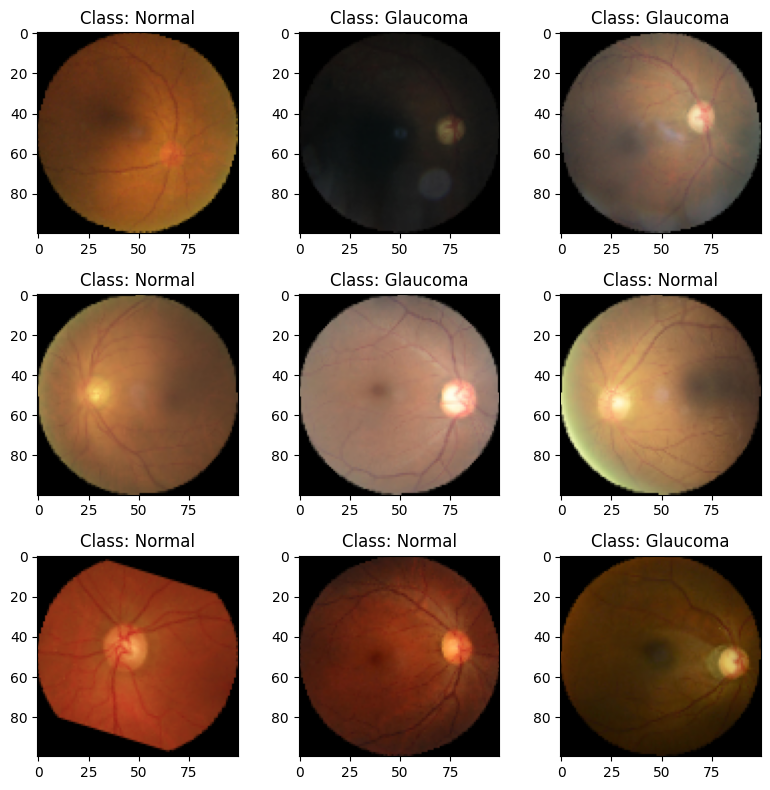

In [269]:
# Check and show images from training data generator

show_images('train')

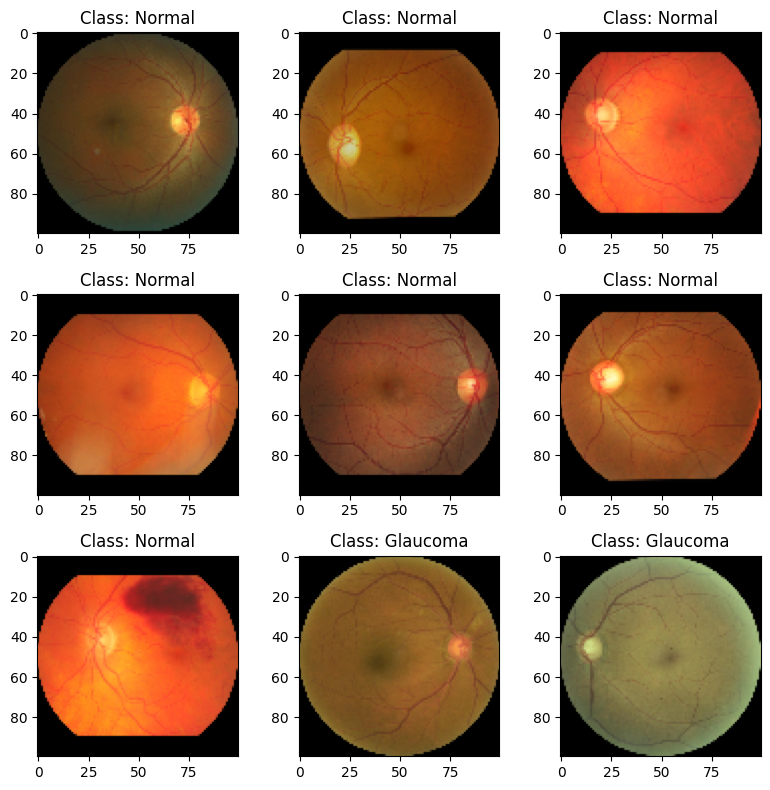

In [270]:
# Check and show images from validation data generator

show_images('val')

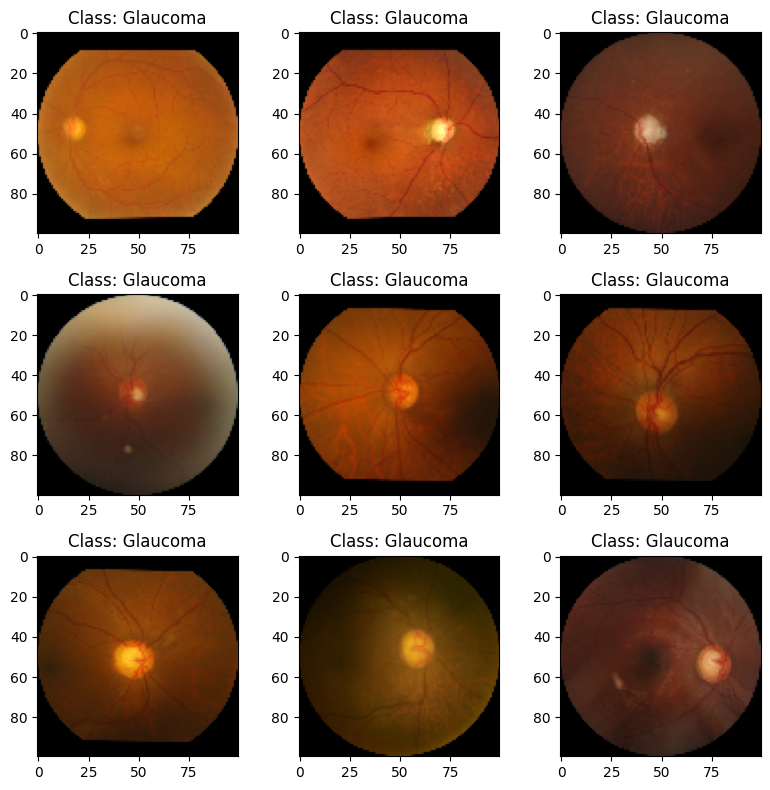

In [271]:
# Check and show images from test data generator

show_images('test')

## Create the base model

In [272]:
# Create the base model from the pre-trained model - MobileNetV3Small

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

## Feature extraction

In [273]:
# Showing all layers name in the base model

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 rescaling_1
2 Conv
3 Conv/BatchNorm
4 tf.__operators__.add_27
5 re_lu_32
6 tf.math.multiply_27
7 multiply_18
8 expanded_conv/depthwise/pad
9 expanded_conv/depthwise
10 expanded_conv/depthwise/BatchNorm
11 re_lu_33
12 expanded_conv/squeeze_excite/AvgPool
13 expanded_conv/squeeze_excite/Conv
14 expanded_conv/squeeze_excite/Relu
15 expanded_conv/squeeze_excite/Conv_1
16 tf.__operators__.add_28
17 re_lu_34
18 tf.math.multiply_28
19 expanded_conv/squeeze_excite/Mul
20 expanded_conv/project
21 expanded_conv/project/BatchNorm
22 expanded_conv_1/expand
23 expanded_conv_1/expand/BatchNorm
24 re_lu_35
25 expanded_conv_1/depthwise/pad
26 expanded_conv_1/depthwise
27 expanded_conv_1/depthwise/BatchNorm
28 re_lu_36
29 expanded_conv_1/project
30 expanded_conv_1/project/BatchNorm
31 expanded_conv_2/expand
32 expanded_conv_2/expand/BatchNorm
33 re_lu_37
34 expanded_conv_2/depthwise
35 expanded_conv_2/depthwise/BatchNorm
36 re_lu_38
37 expanded_conv_2/project
38 expanded_conv_2/project/Batc

### Freeze the trainable layers

In [274]:
base_model.trainable = False

In [275]:
# Take a look at the base model architecture

base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 100, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 50, 50, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 50, 50, 16)  64          ['Conv[0][0]']    

### Add additional top layers

In [276]:
# Create the whole model with some additional top layers

model = tf.keras.Sequential()
model.add(base_model)

# from this layers to the top layer can be modified for further experiments
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 1 unit because this is a binary classification

In [277]:
# Take a look at the new whole model architecture now
# Based on layers that we have added in the code above, we can observe from the model summary in 
# "trainable params" section that there are additional layers 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               147712    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                

### Compile the model

In [278]:
BASE_LR = 0.0001

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR), # Optimizers could be changed for further experiments
      loss='binary_crossentropy',
      metrics=['accuracy',
            #    tf.keras.metrics.BinaryAccuracy(),
            #    tf.keras.metrics.Precision(),
            #    tf.keras.metrics.Recall(),
            #    tf.keras.metrics.AUC(),
            #    tf.keras.metrics.TruePositives(),
            #    tf.keras.metrics.TrueNegatives(),
            #    tf.keras.metrics.FalsePositives(),
            #    tf.keras.metrics.FalseNegatives()
      ])

In [279]:
# Check again whether this model summary is different from before or not

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               147712    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [280]:
len(model.trainable_variables)

8

In [281]:
# Try to evaluate the model using validation dataset before training process

loss0, accuracy0 = model.evaluate(data_sets['val'])

print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

8/8 [==============================] - 4s 179ms/step - loss: 0.7030 - accuracy: 0.4958
Initial loss: 0.70
Initial accuracy: 0.50


### Define some model callbacks

In [282]:
# Define some callbacks for the model

trained_model_path = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\trained_model\\'

# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    trained_model_path + 'mobilenetv3small_glaucoma_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # This could be changed in the future for further experiments
    verbose=1,
    restore_best_weights=True,
    min_delta=0.1 # This could be changed in the future for further experiments
)

# Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8,
    patience=3, 
    min_lr=1e-5, 
    verbose=1
)

# Tensorboard
tensorboard = tf.keras.callbacks.TensorBoard('./tb_logs/run_logs')

### Train the whole model

In [283]:
INIT_EPOCH = 30 # This could be changed for further experiments

history = model.fit(data_sets['train'],
                    epochs=INIT_EPOCH,
                    validation_data=data_sets['val'],
                    callbacks=[model_checkpoint, tensorboard])

Epoch 1/30
283/283 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.6930
Epoch 1: val_loss improved from inf to 0.55627, saving model to D:\Kuliah\Proyek Akhir 2022\eye-disease-classification-app\deep-learning-model\trained_model\mobilenetv3small_glaucoma_best_model.h5
283/283 [==============================] - 127s 435ms/step - loss: 0.5761 - accuracy: 0.6930 - val_loss: 0.5563 - val_accuracy: 0.7101
Epoch 2/30
283/283 [==============================] - ETA: 0s - loss: 0.5116 - accuracy: 0.7439
Epoch 2: val_loss improved from 0.55627 to 0.52156, saving model to D:\Kuliah\Proyek Akhir 2022\eye-disease-classification-app\deep-learning-model\trained_model\mobilenetv3small_glaucoma_best_model.h5
283/283 [==============================] - 95s 335ms/step - loss: 0.5116 - accuracy: 0.7439 - val_loss: 0.5216 - val_accuracy: 0.7353
Epoch 3/30
283/283 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.7652
Epoch 3: val_loss improved from 0.52156 to 0.

### Learning curves

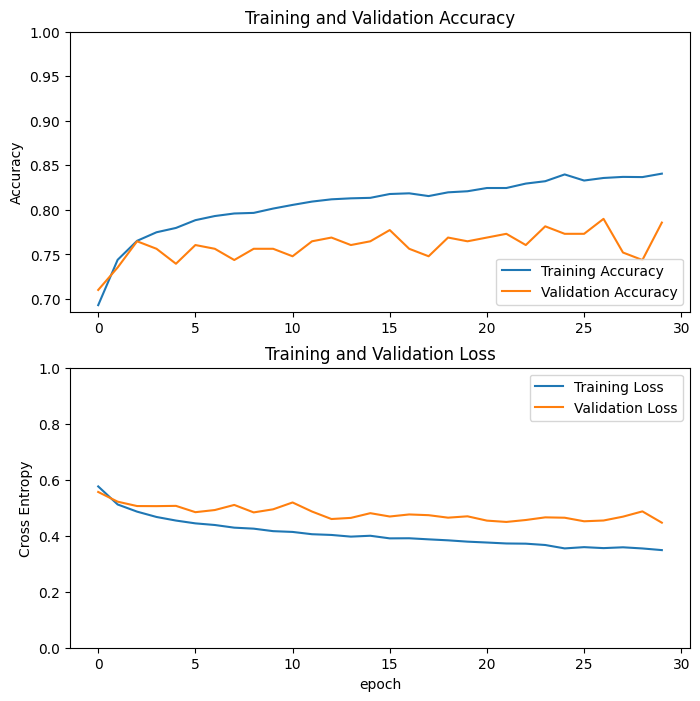

In [284]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

**Explanation of fine tuning**

In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after we have trained the top-level classifier with the pre-trained model set to non-trainable. If we add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and our pre-trained model will forget what it has learned.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

In [285]:
# Un-freeze the base model

base_model.trainable = True

In [286]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100 # This could be changed for further experiments

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 229


### Compile the model

In [287]:
model.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR/10),
    metrics=['accuracy',
        # tf.keras.metrics.BinaryAccuracy(),
        # tf.keras.metrics.Precision(),
        # tf.keras.metrics.Recall(),
        # tf.keras.metrics.AUC(),
        # tf.keras.metrics.TruePositives(),
        # tf.keras.metrics.TrueNegatives(),
        # tf.keras.metrics.FalsePositives(),
        # tf.keras.metrics.FalseNegatives()
    ])

In [288]:
# Take a final look at the model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               147712    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [289]:
len(model.trainable_variables)

81

### Continue training the model

In [290]:
FINE_TUNE_EPOCHS = 10 # This could be changed for further experiments
total_epochs =  INIT_EPOCH + FINE_TUNE_EPOCHS

history_fine = model.fit(data_sets['train'],
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=data_sets['val'])

Epoch 30/40
283/283 [==============================] - 145s 490ms/step - loss: 0.8294 - accuracy: 0.6454 - val_loss: 0.5678 - val_accuracy: 0.7185
Epoch 31/40
283/283 [==============================] - 140s 495ms/step - loss: 0.5973 - accuracy: 0.6957 - val_loss: 0.5184 - val_accuracy: 0.7395
Epoch 32/40
283/283 [==============================] - 141s 499ms/step - loss: 0.5469 - accuracy: 0.7261 - val_loss: 0.5208 - val_accuracy: 0.7311
Epoch 33/40
283/283 [==============================] - 143s 506ms/step - loss: 0.5171 - accuracy: 0.7372 - val_loss: 0.5281 - val_accuracy: 0.7143
Epoch 34/40
283/283 [==============================] - 140s 495ms/step - loss: 0.5026 - accuracy: 0.7539 - val_loss: 0.5205 - val_accuracy: 0.7311
Epoch 35/40
283/283 [==============================] - 139s 489ms/step - loss: 0.4788 - accuracy: 0.7676 - val_loss: 0.5102 - val_accuracy: 0.7395
Epoch 36/40
283/283 [==============================] - 138s 489ms/step - loss: 0.4755 - accuracy: 0.7653 - val_loss: 0

### Learning curves after fine-tuning

In [291]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

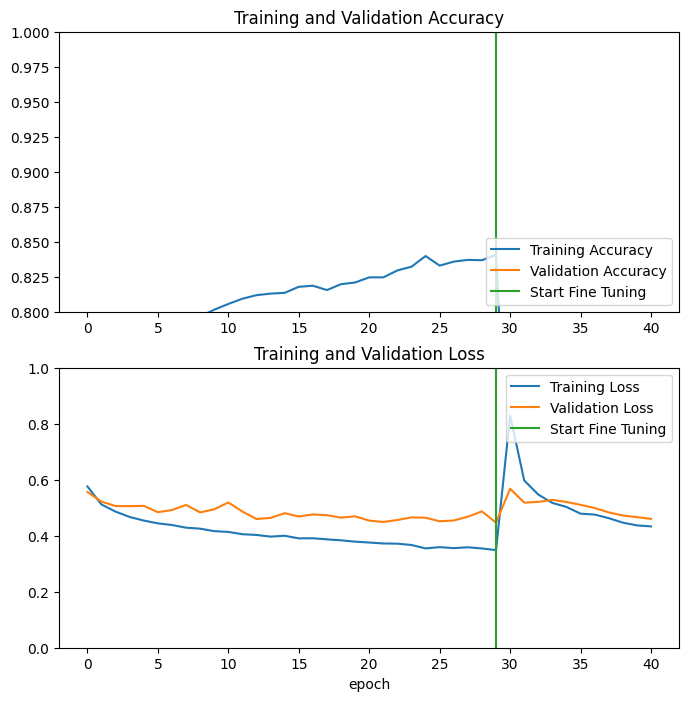

In [292]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation on test dataset

In [293]:
loss, accuracy = model.evaluate(data_sets['test'])

print("Test loss: {:.2f}".format(loss))
print("Test accuracy: {:.2f}".format(accuracy))

8/8 [==============================] - 5s 617ms/step - loss: 0.3940 - accuracy: 0.8208
Test loss: 0.39
Test accuracy: 0.82


## Prediction on test dataset

In [294]:
# # Retrieve a batch of images from the test set
# image_batch, label_batch = data_sets['train'].as_numpy_iterator().next()
# # predictions = model.predict_on_batch(image_batch).flatten()
# 
# # # Apply a sigmoid since our model returns logits
# # predictions = tf.nn.sigmoid(predictions)
# # predictions = tf.where(predictions < 0.5, 0, 1)
# 
# predicted_batch = model.predict(image_batch)
# predicted_id = tf.math.argmax(predicted_batch, axis=1)
# class_names = np.array(class_names)
# predicted_label_batch = class_names[predicted_id]
# 
# # print('Predictions:\n', predictions.numpy())
# print('Predictions:\n', predicted_label_batch)
# print('Labels:\n', label_batch)
# 
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   # plt.title(class_names[predictions[i]])
#   plt.title(predicted_label_batch[i])
#   plt.axis("off")

predictions = model.predict(data_sets['test'])
print('Number of predicted images:', len(predictions))
print('Predictions:', predictions)
print('Predictions shape:', predictions.shape)

predictions_df = pd.DataFrame(predictions)

8/8 [==============================] - 4s 288ms/step
Number of predicted images: 240
Predictions: [[6.10107660e-01]
 [2.62049109e-01]
 [8.87063220e-02]
 [5.52976727e-01]
 [6.24229372e-01]
 [7.48703361e-01]
 [1.68887079e-01]
 [7.55347759e-02]
 [7.93171301e-02]
 [2.85381693e-02]
 [2.07483605e-01]
 [1.37594163e-01]
 [4.96080250e-01]
 [1.54044759e-02]
 [6.59199432e-02]
 [5.31757437e-03]
 [9.09774825e-02]
 [2.98268385e-02]
 [1.72286317e-01]
 [1.87634647e-01]
 [3.03354841e-02]
 [1.85513485e-03]
 [7.19667852e-01]
 [6.34889603e-01]
 [3.02781552e-01]
 [1.32067790e-02]
 [1.58807144e-01]
 [8.70859250e-02]
 [4.75717187e-02]
 [2.80640759e-02]
 [9.01619717e-03]
 [8.47594440e-03]
 [6.95953742e-02]
 [5.66631146e-02]
 [1.85023203e-01]
 [2.74748117e-01]
 [7.29133412e-02]
 [2.08541036e-01]
 [1.41333323e-02]
 [4.04554419e-03]
 [8.53791296e-01]
 [7.90053885e-03]
 [8.25630501e-03]
 [2.47533694e-01]
 [3.56552862e-02]
 [1.48329176e-02]
 [1.19479880e-01]
 [1.39728561e-03]
 [9.07614157e-02]
 [2.55586468e-02]
 [

In [295]:
predictions_df

,0
0,0.610108
1,0.262049
2,0.088706
3,0.552977
4,0.624229
...,...
235,0.898081
236,0.787115
237,0.501196
238,0.508913


In [296]:
# Converts each predicted value into labels

predictions_df['y_pred'] = predictions_df[0].apply(lambda x: 1 if x >= 0.5 else 0)
predictions_df

,0,y_pred
0,0.610108,1
1,0.262049,0
2,0.088706,0
3,0.552977,1
4,0.624229,1
...,...,...
235,0.898081,1
236,0.787115,1
237,0.501196,1
238,0.508913,1


In [297]:
# Add y_true into predictions_df

print(data_sets['test'].classes)
predictions_df['y_true'] = data_sets['test'].classes
predictions_df

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


,0,y_pred,y_true
0,0.610108,1,0
1,0.262049,0,0
2,0.088706,0,0
3,0.552977,1,0
4,0.624229,1,0
...,...,...,...
235,0.898081,1,1
236,0.787115,1,1
237,0.501196,1,1
238,0.508913,1,1


In [298]:
predictions_df.columns = ['prediction_results', 'y_pred', 'y_true']
predictions_df

,prediction_results,y_pred,y_true
0,0.610108,1,0
1,0.262049,0,0
2,0.088706,0,0
3,0.552977,1,0
4,0.624229,1,0
...,...,...,...
235,0.898081,1,1
236,0.787115,1,1
237,0.501196,1,1
238,0.508913,1,1


In [299]:
y_pred_in_numpy = np.array(predictions_df['y_pred'])
y_pred_in_numpy

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [300]:
y_true_in_numpy = np.array(predictions_df['y_true'])
y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [301]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\Kuliah\\Proyek Akhir 2022\\test_dataset_glaucoma_normal.csv'
headers = ['Image', 'Label']

In [302]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [303]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Glaucoma-Normal) (Splitted)\\test'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [304]:
# Load and preview the CSV dataset file

test_glaucoma_df = pd.read_csv('D:\\Kuliah\\Proyek Akhir 2022\\test_dataset_glaucoma_normal.csv')
test_glaucoma_df

,Image,Label
0,BEH-147.png,Glaucoma
1,BEH-3.png,Glaucoma
2,CRFO-v4-4.png,Glaucoma
3,CRFO-v4-8.png,Glaucoma
4,DRISHTI-GS1-test-23.png,Glaucoma
...,...,...
235,REFUGE1-val-74.png,Normal
236,sjchoi86-HRF-130.png,Normal
237,sjchoi86-HRF-131.png,Normal
238,sjchoi86-HRF-193.png,Normal


Glaucoma    120
Normal      120
Name: Label, dtype: int64

Total predicted images: 240


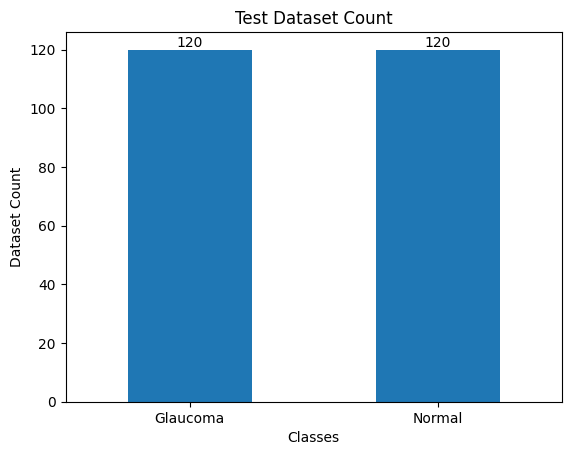

In [305]:
test_glaucoma_df['Label'].value_counts()
print(test_glaucoma_df['Label'].value_counts())

# View the above in a bar graph
test_df_chart = test_glaucoma_df.groupby('Label')['Image'].nunique().plot(kind='bar',
                                                          title='Test Dataset Count',
                                                          xlabel='Classes',
                                                          ylabel='Dataset Count',
                                                          rot=0)

test_df_chart.bar_label(test_df_chart.containers[0])

# Lets print the total predicted images 
print("\nTotal predicted images:", test_glaucoma_df.shape[0])



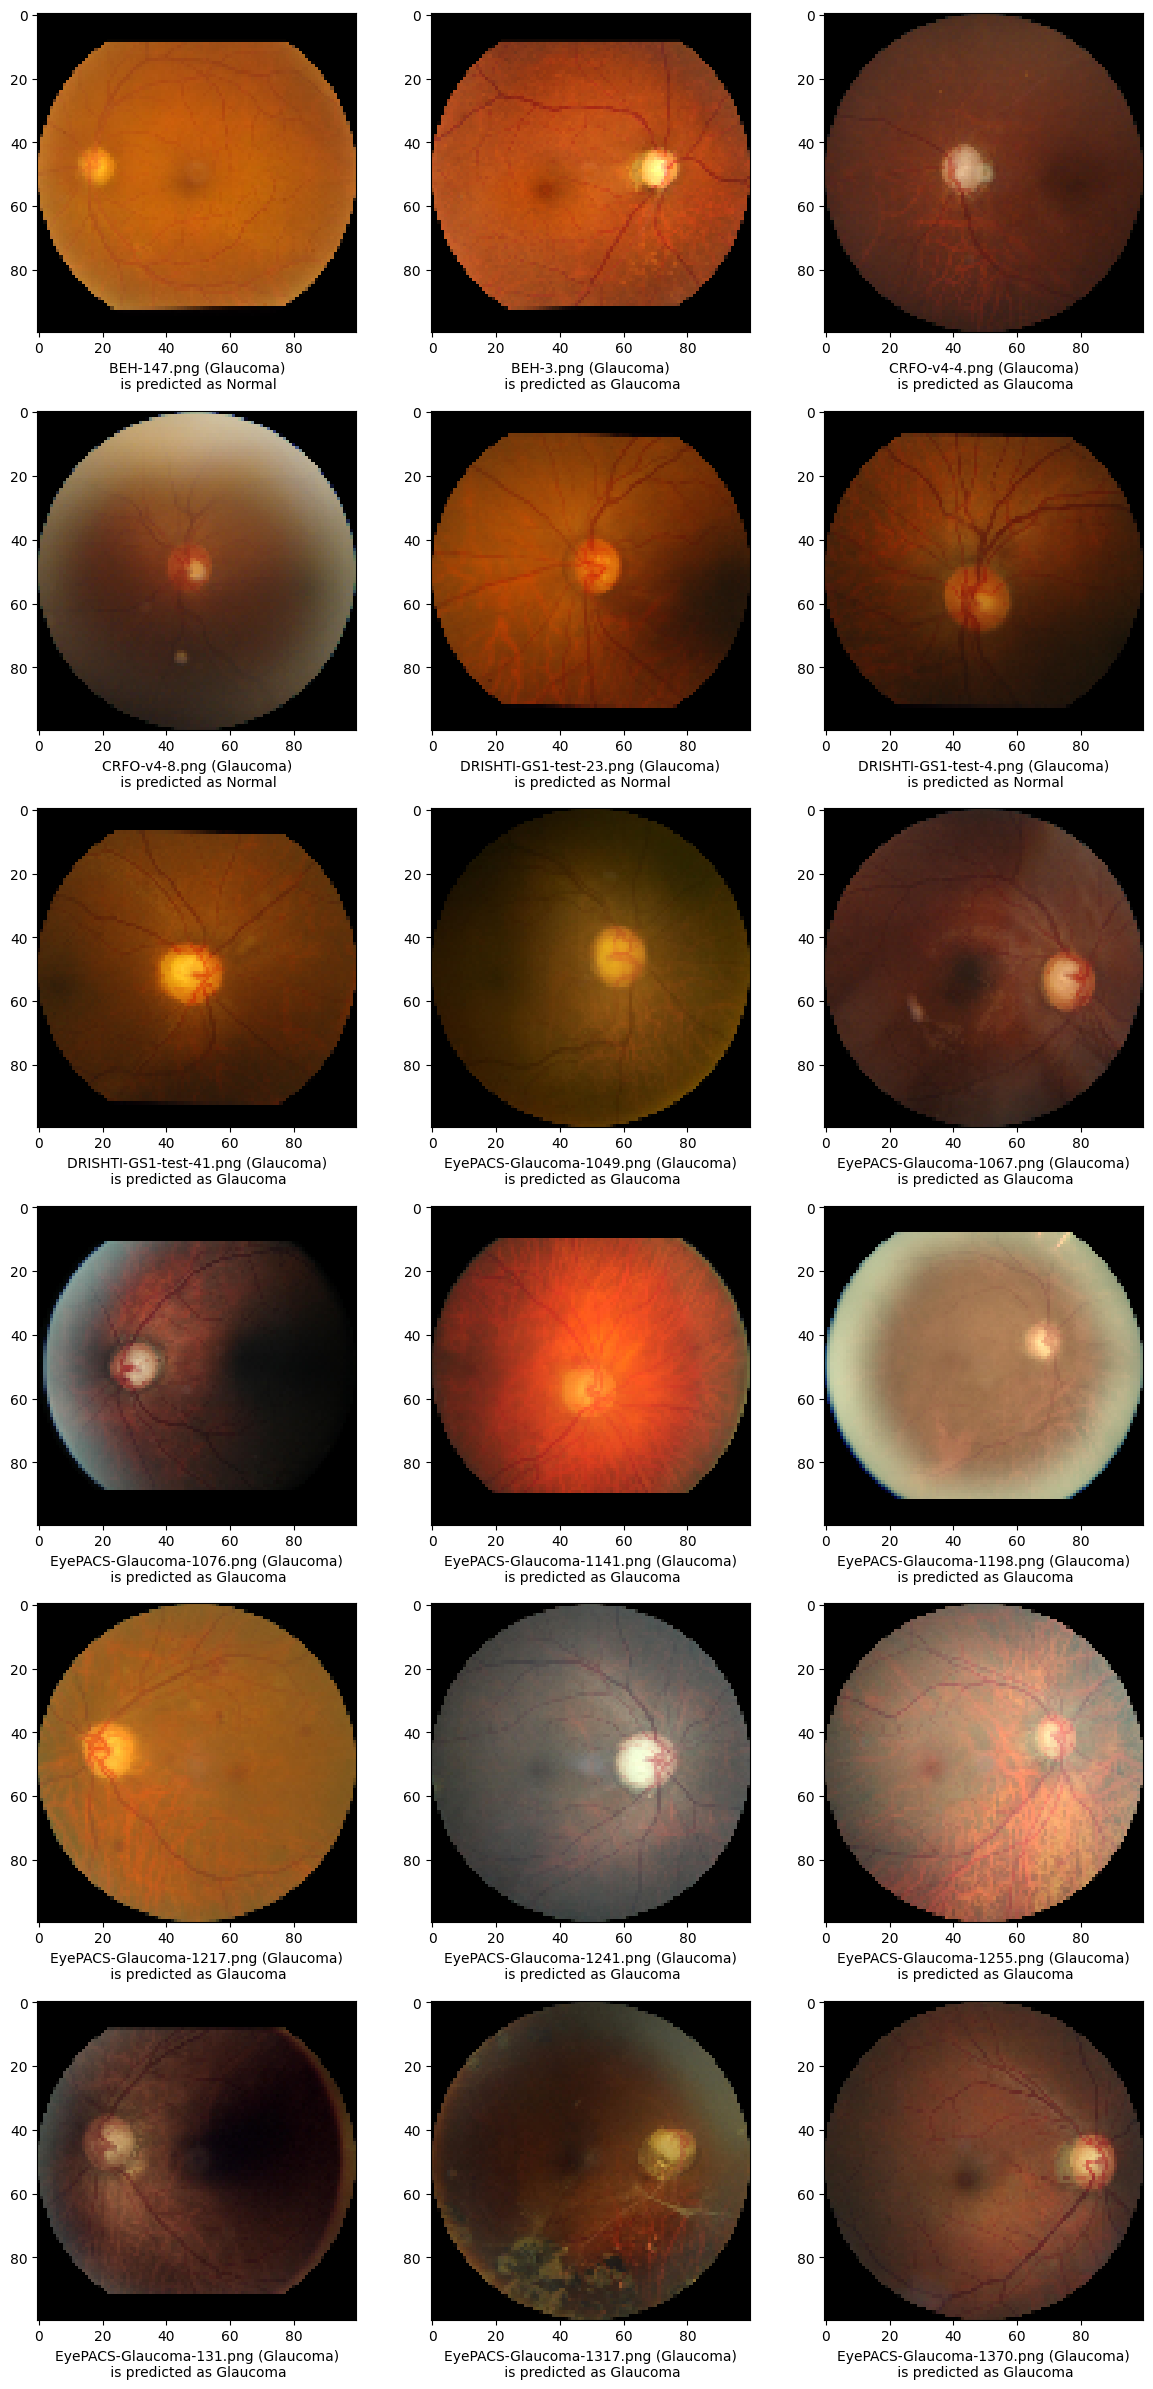

In [306]:
from tensorflow.keras.preprocessing.image import load_img

sample_test = test_glaucoma_df.head(18)
sample_test.head()
class_indices = data_sets['test'].class_indices
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['Label']
    y_pred = predictions_df['y_pred'][index]
    classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
    img = load_img('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Glaucoma-Normal) (Splitted)\\test\\Glaucoma\\' + filename, target_size=IMG_SIZE) #rescale(1./255)
    plt.subplot(6, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

plt.tight_layout()
plt.show()

## Evaluation metrics

In [307]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true_in_numpy, y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true_in_numpy, y_pred_in_numpy, target_names=class_names))




Accuracy: 0.82

Micro Precision: 0.82
Micro Recall: 0.82
Micro F1-score: 0.82

Macro Precision: 0.82
Macro Recall: 0.82
Macro F1-score: 0.82

Weighted Precision: 0.82
Weighted Recall: 0.82
Weighted F1-score: 0.82


Classification Report

              precision    recall  f1-score   support

    Glaucoma       0.83      0.80      0.82       120
      Normal       0.81      0.84      0.82       120

    accuracy                           0.82       240
   macro avg       0.82      0.82      0.82       240
weighted avg       0.82      0.82      0.82       240



[[ 96  24]
 [ 19 101]]


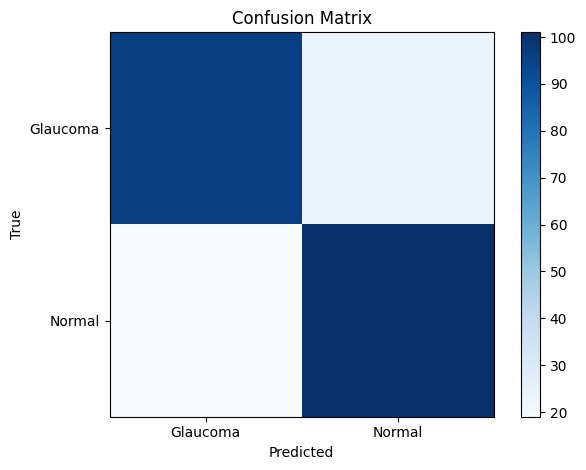

In [308]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_in_numpy, y_pred_in_numpy)
print(cm)

# Create labels for the matrix
labels = list(data_sets['test'].class_indices.keys())

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=0)
plt.yticks(tick_marks, labels)

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.tight_layout()
plt.show()

In [309]:
fpr, tpr, thresholds = roc_curve(y_true_in_numpy, y_pred_in_numpy)

In [310]:
roc_auc = auc(fpr, tpr)

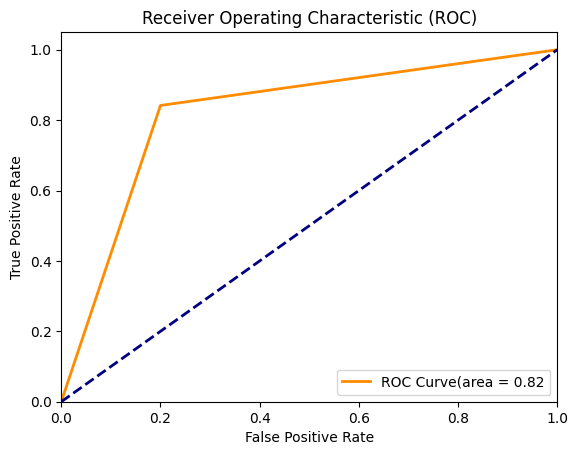

In [311]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC Curve(area = %0.2f' %roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = 'lower right')

In [312]:
roc_auc_score_ = roc_auc_score(y_true_in_numpy, y_pred_in_numpy)
print(f'ROC AUC Score: {roc_auc_score_:.4f}') 

ROC AUC Score: 0.8208


## Save the model

In [313]:
# model.save('')

## Use trained model for prediction

In [314]:
from tensorflow.keras.models import load_model, model_from_json, save_model

saved_model = load_model('D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\trained_model\\mobilenetv3small_glaucoma_best_model.h5', compile=True)

In [315]:
new_prediction_result = saved_model.predict(data_sets['test'])
print('Number of new predicted images:', len(new_prediction_result))
print('New prediction result:', new_prediction_result)
print('New prediction result shape:', new_prediction_result.shape)

new_predictions_df = pd.DataFrame(new_prediction_result)

8/8 [==============================] - 4s 256ms/step
Number of new predicted images: 240
New prediction result: [[6.60021067e-01]
 [3.02422315e-01]
 [3.05610057e-02]
 [4.49533224e-01]
 [2.26512015e-01]
 [6.69212162e-01]
 [2.98342314e-02]
 [6.43131807e-02]
 [1.81024075e-01]
 [2.47950829e-03]
 [1.56060427e-01]
 [1.41242474e-01]
 [3.61889720e-01]
 [5.70513681e-03]
 [8.03775266e-02]
 [2.28244462e-03]
 [7.81589448e-01]
 [6.23711310e-02]
 [2.36241817e-02]
 [2.52049733e-02]
 [1.91434976e-02]
 [2.58884230e-03]
 [7.07586408e-01]
 [8.66600513e-01]
 [4.68020052e-01]
 [1.27202524e-02]
 [8.67573991e-02]
 [2.32338291e-02]
 [2.03000512e-02]
 [1.70230819e-03]
 [8.87872465e-03]
 [3.31815071e-02]
 [1.48226153e-02]
 [1.00730741e-02]
 [4.62640598e-02]
 [1.48543432e-01]
 [1.08725026e-01]
 [4.27125573e-01]
 [3.46619752e-03]
 [7.31708901e-03]
 [5.76916575e-01]
 [6.70471117e-02]
 [3.82272585e-04]
 [6.67275071e-01]
 [1.70724343e-05]
 [3.92667465e-02]
 [3.97828706e-02]
 [1.45936885e-03]
 [9.64445341e-03]
 [1.04

In [316]:
new_predictions_df

,0
0,0.660021
1,0.302422
2,0.030561
3,0.449533
4,0.226512
...,...
235,0.955681
236,0.203466
237,0.489810
238,0.778244


In [317]:
# Converts each predicted value into labels

new_predictions_df['y_pred'] = new_predictions_df[0].apply(lambda x: 1 if x >= 0.5 else 0)
new_predictions_df

,0,y_pred
0,0.660021,1
1,0.302422,0
2,0.030561,0
3,0.449533,0
4,0.226512,0
...,...,...
235,0.955681,1
236,0.203466,0
237,0.489810,0
238,0.778244,1


In [318]:
# Add y_true into new_predictions_df

print(data_sets['test'].classes)
new_predictions_df['y_true'] = data_sets['test'].classes
new_predictions_df

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


,0,y_pred,y_true
0,0.660021,1,0
1,0.302422,0,0
2,0.030561,0,0
3,0.449533,0,0
4,0.226512,0,0
...,...,...,...
235,0.955681,1,1
236,0.203466,0,1
237,0.489810,0,1
238,0.778244,1,1


In [319]:
new_predictions_df.columns = ['prediction_results', 'y_pred', 'y_true']
new_predictions_df

,prediction_results,y_pred,y_true
0,0.660021,1,0
1,0.302422,0,0
2,0.030561,0,0
3,0.449533,0,0
4,0.226512,0,0
...,...,...,...
235,0.955681,1,1
236,0.203466,0,1
237,0.489810,0,1
238,0.778244,1,1


In [320]:
new_y_pred_in_numpy = np.array(new_predictions_df['y_pred'])
new_y_pred_in_numpy

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
      dtype=int64)

In [321]:
new_y_true_in_numpy = np.array(new_predictions_df['y_true'])
new_y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [322]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\Kuliah\\Proyek Akhir 2022\\new_test_dataset_glaucoma_normal.csv'
headers = ['Image', 'Label']

In [323]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [324]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Glaucoma-Normal) (Splitted)\\test'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [325]:
# Load and preview the CSV dataset file

new_test_glaucoma_df = pd.read_csv('D:\\Kuliah\\Proyek Akhir 2022\\new_test_dataset_glaucoma_normal.csv')
new_test_glaucoma_df

,Image,Label
0,BEH-147.png,Glaucoma
1,BEH-3.png,Glaucoma
2,CRFO-v4-4.png,Glaucoma
3,CRFO-v4-8.png,Glaucoma
4,DRISHTI-GS1-test-23.png,Glaucoma
...,...,...
235,REFUGE1-val-74.png,Normal
236,sjchoi86-HRF-130.png,Normal
237,sjchoi86-HRF-131.png,Normal
238,sjchoi86-HRF-193.png,Normal


Glaucoma    120
Normal      120
Name: Label, dtype: int64

Total predicted images: 240


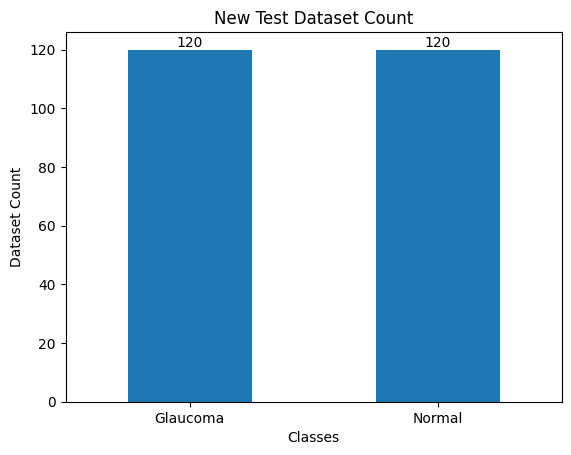

In [326]:
new_test_glaucoma_df['Label'].value_counts()
print(new_test_glaucoma_df['Label'].value_counts())

# View the above in a bar graph
new_test_df_chart = new_test_glaucoma_df.groupby('Label')['Image'].nunique().plot(
    kind='bar',
    title='New Test Dataset Count',
    xlabel='Classes',
    ylabel='Dataset Count',
    rot=0
)

new_test_df_chart.bar_label(new_test_df_chart.containers[0])

# Lets print the total predicted images 
print("\nTotal predicted images:", new_test_glaucoma_df.shape[0])



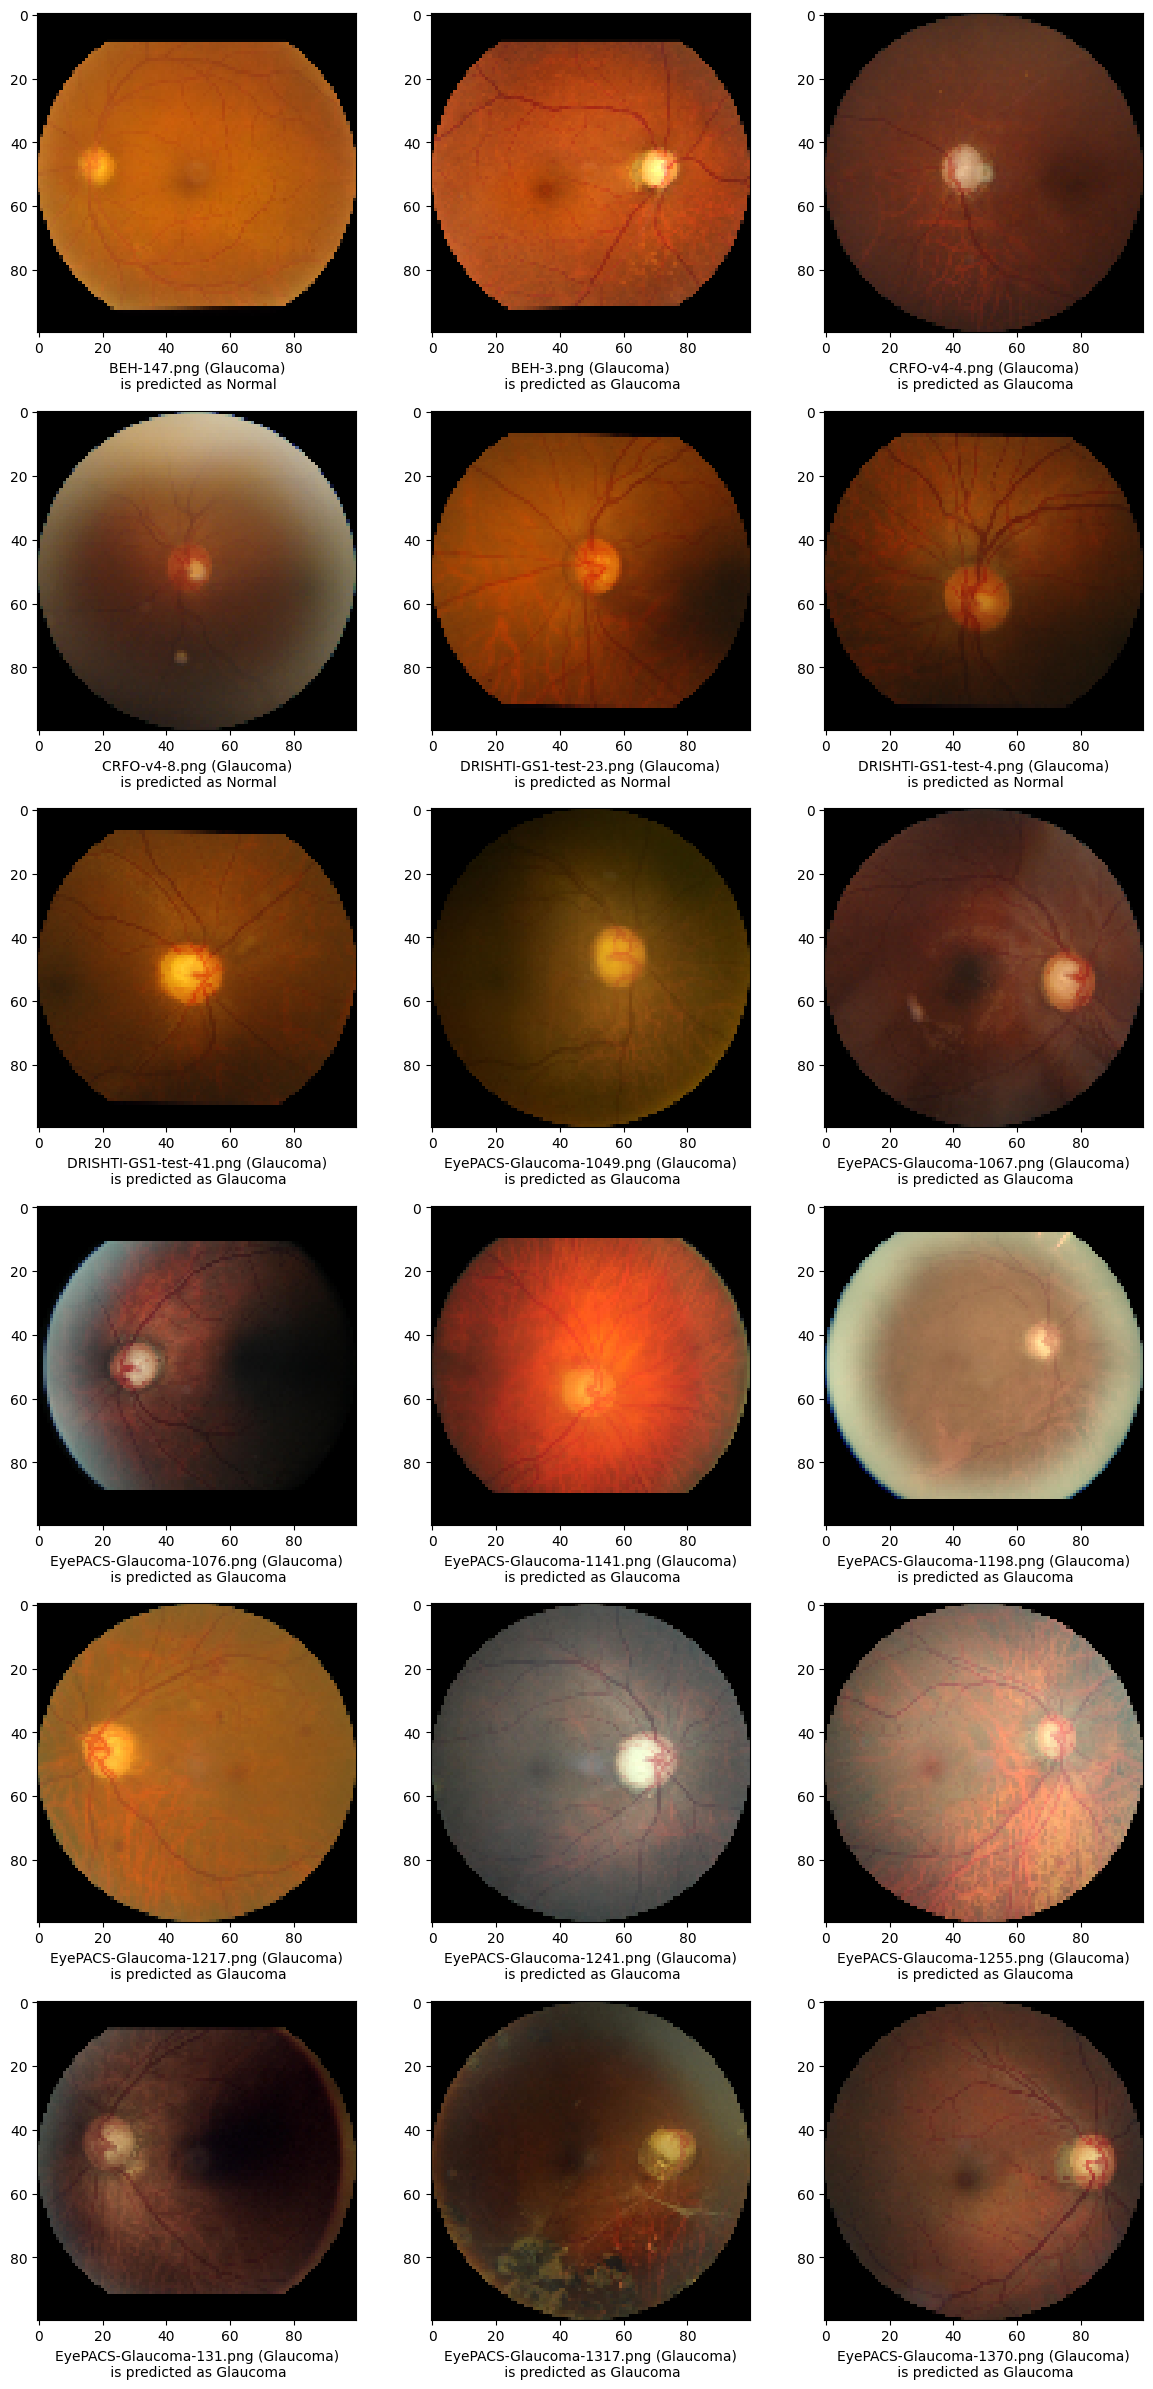

In [327]:
from tensorflow.keras.preprocessing.image import load_img

sample_test = new_test_glaucoma_df.head(18)
sample_test.head()
class_indices = data_sets['test'].class_indices
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['Label']
    y_pred = predictions_df['y_pred'][index]
    classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
    img = load_img('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Glaucoma-Normal) (Splitted)\\test\\Glaucoma\\' + filename, target_size=IMG_SIZE) #rescale(1./255)
    plt.subplot(6, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

plt.tight_layout()
plt.show()

In [328]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(new_y_true_in_numpy, new_y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(new_y_true_in_numpy, new_y_pred_in_numpy, target_names=class_names))




Accuracy: 0.82

Micro Precision: 0.82
Micro Recall: 0.82
Micro F1-score: 0.82

Macro Precision: 0.82
Macro Recall: 0.82
Macro F1-score: 0.82

Weighted Precision: 0.82
Weighted Recall: 0.82
Weighted F1-score: 0.82


Classification Report

              precision    recall  f1-score   support

    Glaucoma       0.80      0.85      0.82       120
      Normal       0.84      0.78      0.81       120

    accuracy                           0.82       240
   macro avg       0.82      0.82      0.82       240
weighted avg       0.82      0.82      0.82       240



In [329]:
# Let's try, if the model can predict just one image

from tensorflow.keras.preprocessing import image

def predict_one_image(img_path, model=model):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    
    print(img_array.shape) 
    print(type(img_array))
    
    prediction_result = model.predict(img_array)
    
    print('Prediction_result:', prediction_result)    
    print('Prediction_result shape:', prediction_result.shape)    
    print('Prediction_result type:', type(prediction_result))    

    if prediction_result[0] > 0.5:
        predicted_class = class_names[1]
    else:
        predicted_class = class_names[0]
    
    print('Prediction_class:', predicted_class)

glaucoma_normal_test_image = test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\glaucoma_test_images\\mixed - 10 - normal (661).jpg'
predict_one_image(glaucoma_normal_test_image, saved_model)

(1, 100, 100, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 [==============================] - 1s 1s/step
Prediction_result: [[0.8834074]]
Prediction_result shape: (1, 1)
Prediction_result type: <class 'numpy.ndarray'>
Prediction_class: Normal
